In [202]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler   # u otros scalers
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score

In [203]:
### carga datos de dataset en dataframe
file_path= 'uber_fares.csv'

df = pd.read_csv(file_path)

In [204]:
### visualizacion de algunos datos
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


#### Contexto  
El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

In [205]:
### Columnas, ¿cuáles son variables numéricas y cuales variables categóricas?
df.columns

Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [207]:
# Única fila con valores nulos.
df[df["dropoff_longitude"].isna()]

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
87946,32736015,2013-07-02 03:51:57.0000001,24.1,2013-07-02 03:51:57 UTC,-73.950581,40.779692,NaN,NaN,0


In [208]:
df.duplicated().values.any()

np.False_

In [209]:
df.isna().values.any()

np.True_

In [210]:
# Función para calcular la distancia del viaje en base a las coordenadas 
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # radio de la Tierra en km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c


In [211]:
# Función para asignar la franja horaria
def obtener_franja_horaria(hora):
    if 0 <= hora <= 5:
        return 'Madrugada'
    elif 6 <= hora <= 9:
        return 'Mañana'
    elif 10 <= hora <= 15:
        return 'Mediodia/Tarde'
    elif 16 <= hora <= 19:
        return 'Tarde'
    else:
        return 'Noche'

In [212]:
# Creación de copia del df para evitar conflictos.
df_copy = df.copy()

In [213]:
# Conversión de tipo de datos y creación de columnas. 
df_copy["passenger_count"] = df_copy["passenger_count"].astype("Int64")
df_copy["date"] = pd.to_datetime(df_copy["date"])
df_copy['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [214]:
df_copy['fin_de_semana'] = df_copy['pickup_datetime'].dt.weekday.apply(lambda x: 1 if x > 5 else 0)

In [215]:
df_copy["distance_km"] = haversine(
    df_copy["pickup_latitude"], df_copy["pickup_longitude"],
    df_copy["dropoff_latitude"], df_copy["dropoff_longitude"]
)

In [ ]:
# Eliminacióin de columna redundante, igual que pickup_datetime
df_copy = df_copy.drop("date",axis=1)

In [225]:
# Aplicar la función a la columna de la hora para crear la nueva variable categórica
df_copy['franja_horaria'] = df_copy['pickup_datetime'].dt.hour.apply(obtener_franja_horaria)

In [228]:
df_copy.sample(10)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fin_de_semana,distance_km,franja_horaria
12057,51734495,4.50,2012-06-19 12:53:00+00:00,-73.989873,40.757603,-73.985020,40.762817,2,0,0.709368,Mediodia/Tarde
91233,33175967,6.00,2014-02-12 06:56:42+00:00,-73.966103,40.790131,-73.963176,40.804007,2,0,1.562490,Mañana
10288,25358935,35.00,2013-07-01 17:50:10+00:00,-73.783266,40.648591,-73.685152,40.686309,1,0,9.277264,Tarde
131418,33745930,45.00,2010-10-25 18:57:00+00:00,-73.790038,40.646890,-73.980142,40.760650,5,0,20.415943,Tarde
133411,25535395,10.00,2014-03-08 23:08:00+00:00,-73.988642,40.722492,-74.000830,40.738145,5,0,2.020932,Noche
17723,48194348,6.50,2010-05-06 09:39:00+00:00,-73.976413,40.754350,-73.969293,40.768438,5,0,1.677369,Mañana
25410,17660952,6.90,2009-01-11 00:56:00+00:00,-73.988892,40.720182,-73.981885,40.740425,5,1,2.327067,Madrugada
150831,53886234,31.33,2014-01-10 23:41:00+00:00,-73.864807,40.770302,-73.952217,40.826787,3,0,9.674006,Noche
80402,23979980,10.00,2012-11-30 09:14:23+00:00,0.000000,0.000000,0.000000,0.000000,1,0,0.000000,Mañana
126375,45554101,18.00,2013-03-18 23:04:59+00:00,-73.986302,40.722070,-73.983002,40.774253,2,0,5.809140,Noche


Preguntar por imputación de distancia 0.

In [229]:
df_copy[df_copy["distance_km"] == 0]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fin_de_semana,distance_km,franja_horaria
5,44470845,4.9,2011-02-12 02:27:09+00:00,-73.969019,40.755910,-73.969019,40.755910,1,0,0.0,Madrugada
7,44195482,2.5,2012-12-11 13:52:00+00:00,0.000000,0.000000,0.000000,0.000000,1,0,0.0,Mediodia/Tarde
11,6379048,8.5,2011-05-23 22:15:00+00:00,0.000000,0.000000,0.000000,0.000000,1,0,0.0,Noche
48,22405517,56.8,2013-01-03 22:24:41+00:00,-73.993498,40.764686,-73.993498,40.764686,1,0,0.0,Noche
65,21993993,6.0,2014-05-05 19:27:00+00:00,0.000000,0.000000,0.000000,0.000000,1,0,0.0,Tarde
...,...,...,...,...,...,...,...,...,...,...,...
199880,35013970,6.5,2014-02-22 06:45:46+00:00,0.000000,0.000000,0.000000,0.000000,1,0,0.0,Mañana
199883,44115598,12.5,2012-09-10 17:39:00+00:00,0.000000,0.000000,0.000000,0.000000,2,0,0.0,Tarde
199917,45368488,4.5,2013-06-24 22:17:43+00:00,-73.793768,40.656939,-73.793768,40.656939,1,0,0.0,Noche
199932,46517645,24.9,2011-03-22 13:59:00+00:00,-73.974618,40.756295,-73.974618,40.756295,5,0,0.0,Mediodia/Tarde


In [230]:
df_copy.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'fin_de_semana', 'distance_km', 'franja_horaria'],
      dtype='object')

In [233]:
df_copy[[column for column in df_copy.columns if column != "key"]].describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fin_de_semana,distance_km
count,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.0,200000.000000,199999.000000
mean,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535,0.132205,20.855350
std,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997,0.338714,382.964642
min,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.0,0.000000,0.000000
25%,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.0,0.000000,1.215222
50%,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.0,0.000000,2.120992
75%,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.0,0.000000,3.875169
max,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.0,1.000000,16409.239135


In [ ]:
# valores raros en cantidad de pasajeros 
df_copy[df_copy["passenger_count"] > 5]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fin_de_semana,distance_km,franja_horaria
145,26097408,38.54,2015-06-16 09:54:20+00:00,-73.862762,40.768791,-73.978737,40.753040,6,0,9.923555,Mañana
252,47000984,10.50,2015-03-10 15:28:28+00:00,-73.981239,40.752876,-73.995277,40.726177,6,0,3.195716,Mediodia/Tarde
390,41017257,4.50,2012-03-28 14:50:00+00:00,-73.989575,40.758767,-73.969325,40.766030,6,0,1.887041,Mediodia/Tarde
392,6846668,22.00,2013-02-01 23:11:00+00:00,-73.978450,40.736707,-73.934902,40.810442,6,0,8.981665,Noche
416,9333664,5.00,2013-05-20 15:15:00+00:00,-73.977120,40.745432,-73.974743,40.750415,6,0,0.589156,Mediodia/Tarde
...,...,...,...,...,...,...,...,...,...,...,...
199796,4878584,9.00,2014-07-17 14:08:00+00:00,-73.970375,40.761642,-73.980985,40.757700,6,0,0.995342,Mediodia/Tarde
199876,23080911,11.30,2012-04-24 08:38:00+00:00,-73.973325,40.748505,-74.004147,40.741472,6,0,2.711771,Mañana
199890,4537307,7.00,2013-10-15 02:08:00+00:00,-73.989767,40.725547,-74.002000,40.716875,6,0,1.411609,Madrugada
199893,7525392,6.00,2013-05-04 10:58:00+00:00,-73.972245,40.749600,-73.984660,40.732842,6,0,2.136885,Mediodia/Tarde


In [237]:
# Valores raros en columna de precios 
print(len(df_copy[df_copy["fare_amount"] > 150]))
df_copy[df_copy["fare_amount"] > 150]

23


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fin_de_semana,distance_km,franja_horaria
4292,33491441,350.00,2014-10-24 20:20:00+00:00,0.000000,0.000000,0.000000,0.000000,3,0,0.000000,Noche
18415,11328919,190.00,2012-07-29 08:28:11+00:00,-73.797236,40.665420,-73.101445,40.812208,1,1,60.851156,Mañana
19509,38458832,180.00,2015-06-14 19:07:53+00:00,-73.567558,41.047142,-73.567596,41.047127,1,1,0.003621,Tarde
23682,38390943,206.38,2014-11-02 22:40:20+00:00,-73.782161,40.644601,-74.449079,40.836457,1,1,60.100889,Noche
29261,5471406,220.00,2013-09-27 12:36:11+00:00,-73.801147,40.671653,-73.790402,40.646742,1,0,2.914493,Mediodia/Tarde
33911,13732511,192.33,2014-03-12 19:12:28+00:00,-73.542097,41.052430,-73.542097,41.052430,2,0,0.000000,Tarde
39716,24176217,191.80,2012-06-26 22:28:00+00:00,-73.822978,40.788500,-73.548110,41.045037,1,0,36.703299,Noche
45094,15547641,170.00,2014-11-10 16:55:00+00:00,-73.789297,40.643437,-74.402822,40.698832,1,0,52.108219,Tarde
53996,49601150,171.35,2014-01-08 01:09:06+00:00,-74.291586,40.768783,-74.291589,40.768786,1,0,0.000418,Madrugada
71715,38680012,250.00,2013-05-11 00:31:00+00:00,0.000000,0.000000,0.000000,0.000000,1,0,0.000000,Madrugada


In [ ]:
# Valores atípicos en distancia(valores faltantes en lat/long)
df_copy[df_copy["distance_km"] > 60]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fin_de_semana,distance_km,franja_horaria
346,25741482,15.5,2015-03-05 19:15:07+00:00,0.000000,0.000000,-73.979805,40.786030,1,0,8666.398012,Tarde
1067,10614181,52.0,2014-02-02 22:27:00+00:00,-73.781095,40.645015,0.000000,0.000000,1,1,8647.035598,Noche
1526,16419344,2.5,2014-05-12 12:00:15+00:00,-74.001849,40.715156,0.000000,0.000000,3,0,8666.772408,Mediodia/Tarde
1945,915515,7.0,2013-02-10 16:18:00+00:00,-0.131667,40.757063,-73.991593,40.749953,1,1,6021.114289,Tarde
2167,7976070,5.7,2012-07-21 12:16:00+00:00,-1.216667,40.748597,-74.004822,40.734670,1,0,5941.059801,Mediodia/Tarde
...,...,...,...,...,...,...,...,...,...,...,...
198567,29279997,23.5,2013-10-21 01:28:00+00:00,-73.968115,40.801455,0.000000,0.000000,2,0,8665.747167,Madrugada
198665,35767571,20.1,2012-06-26 21:29:00+00:00,-0.116667,40.729775,0.000000,0.000000,5,0,4528.959683,Noche
199403,26201357,7.0,2013-01-20 17:58:29+00:00,-67.370360,39.999790,-73.971058,40.753000,1,1,565.234582,Tarde
199641,50369727,8.1,2012-06-22 12:36:00+00:00,-74.000143,40.742877,-7.995197,40.759382,5,0,5419.533753,Mediodia/Tarde


<Axes: xlabel='fare_amount', ylabel='Count'>

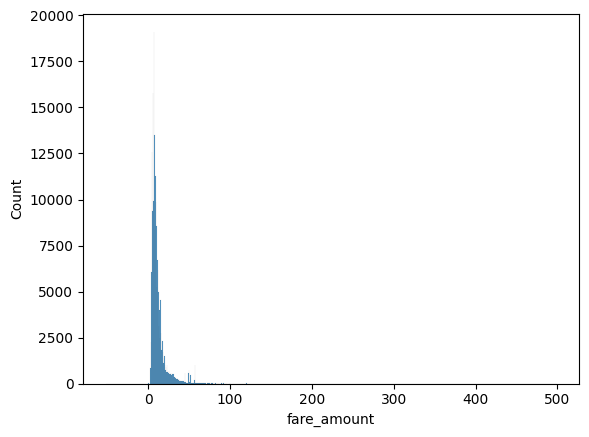

In [239]:
sns.histplot(df["fare_amount"])

<Axes: xlabel='distance_km', ylabel='Count'>

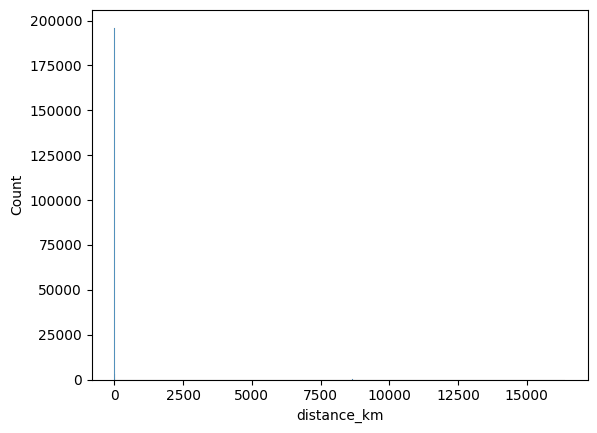

In [241]:
sns.histplot(df_copy["distance_km"])

<Axes: xlabel='passenger_count', ylabel='Count'>

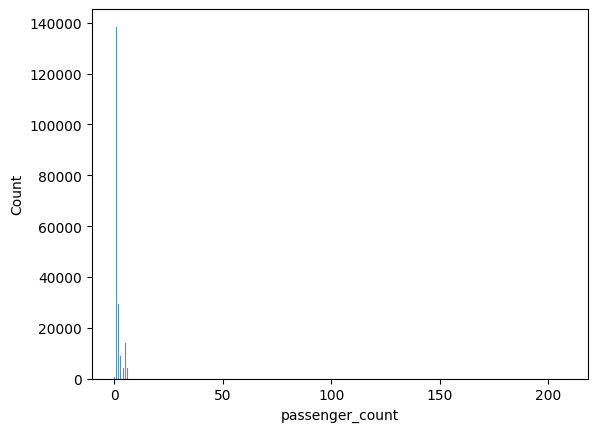

In [242]:
sns.histplot(df["passenger_count"])

In [218]:
X_train, X_test, y_train, y_test = train_test_split(df_copy.drop(columns='fare_amount'), df_copy['fare_amount'], test_size=0.2, random_state=42)

In [219]:
X_train.describe()

,key,date,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fin_de_semana,distance_km
count,1.600000e+05,160000,160000.000000,160000.000000,159999.000000,159999.000000,160000.0,160000.000000,159999.000000
mean,2.771233e+07,2012-03-22 02:59:10.791006464,-72.525896,39.936265,-72.525260,39.919258,1.684988,0.132837,20.591193
min,1.000000e+00,2009-01-01 01:15:22.000000600,-1340.648410,-74.015515,-3356.666300,-881.985513,0.0,0.000000,0.000000
25%,1.379326e+07,2010-08-24 21:11:25.250000128,-73.992062,40.734842,-73.991433,40.733835,1.0,0.000000,1.217936
50%,2.775608e+07,2012-03-21 17:29:17.500000512,-73.981834,40.752594,-73.980080,40.753044,1.0,0.000000,2.125300
75%,4.155845e+07,2013-10-18 07:11:55,-73.967212,40.767116,-73.963614,40.768055,2.0,0.000000,3.874418
max,5.542357e+07,2015-06-30 23:40:39.000000100,57.418457,1644.421482,1153.572603,872.697628,208.0,1.000000,16409.239135
std,1.603218e+07,NaN,11.557753,8.090121,13.611271,6.880320,1.405686,0.339400,380.549053


In [220]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160000 entries, 153248 to 121958
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                160000 non-null  int64              
 1   date               160000 non-null  datetime64[ns]     
 2   pickup_datetime    160000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   160000 non-null  float64            
 4   pickup_latitude    160000 non-null  float64            
 5   dropoff_longitude  159999 non-null  float64            
 6   dropoff_latitude   159999 non-null  float64            
 7   passenger_count    160000 non-null  Int64              
 8   fin_de_semana      160000 non-null  int64              
 9   distance_km        159999 non-null  float64            
 10  franja_horaria     160000 non-null  object             
dtypes: Int64(1), datetime64[ns, UTC](1), datetime64[ns](1), float64(5), int64(2), object(1)
mem

In [221]:
X_train.shape[0],X_test.shape[0]

(160000, 40000)

In [222]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 160000 entries, 153248 to 121958
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                160000 non-null  int64              
 1   date               160000 non-null  datetime64[ns]     
 2   pickup_datetime    160000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   160000 non-null  float64            
 4   pickup_latitude    160000 non-null  float64            
 5   dropoff_longitude  159999 non-null  float64            
 6   dropoff_latitude   159999 non-null  float64            
 7   passenger_count    160000 non-null  Int64              
 8   fin_de_semana      160000 non-null  int64              
 9   distance_km        159999 non-null  float64            
 10  franja_horaria     160000 non-null  object             
dtypes: Int64(1), datetime64[ns, UTC](1), datetime64[ns](1), float64(5), int64(2), object(1)
mem